# DNN: analysis with Keras of 2D data

# Components of the group

- Marco Boscolo&emsp;&emsp;&emsp;2157559
- Francesco La Rovere&nbsp; 2164968
- Nicolò Montagner&emsp;&ensp; 2165809
- Raffaele Sabatini&emsp;&emsp; 2165739

# Importing libraries and packeges

In [2]:
import numpy as np #Always usefull and to be used

import keras
import tensorflow.random as tf_r
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import layers
import keras_tuner
# Added to visualize the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

from useful import *


# default font
plt.rcParams['font.size'] = 13

%run useful.py

# training data
perc_train = 0.8

# Defining useful functions

We modify a bit the funcions of the given notebook in order to use them multiple times in the notebook.
We also add the function to compute and plot the confusion matrix.
The reduce function is in this section because with "reduce_rate=1" it just split the dataset in training and validation/test sets.

In [25]:
# Show the result of a model along the projection on the first 2 components (the relevant ones)
def PlotPrediction(x, y, xM, xS, Model, whichModel):

    L = 8
    B = 10

    dX = .05
    X1 = np.arange(0, 10+dX, dX)
    LG = len(X1)
    X, Y = np.meshgrid(X1, X1)
    allXY = np.reshape((np.array((X,Y)).T), (LG**2,2))
    grid = np.random.rand(LG**2, L)*B
    grid[:,:2] = allXY
    grid_r = Standardize(grid, xM, xS)

    pred = Model.predict(grid_r)

    fig, AX = plt.subplots(1, 3, figsize = (18,6))
    fig.suptitle(f"Prediction with {whichModel} model", fontsize = 20)

    ax = AX[0]
    ax.scatter(x[:,0], x[:,1], c=y, s=6)
    ax.set_title("Data", fontsize = 12)

    ax = AX[1]
    ax.pcolormesh(X1,X1,pred.reshape((LG, LG)))
    ax.set_title("prediction $\\hat y$")

    ax = AX[2]
    pred01=np.copy(pred)
    pred01[pred>0.5]=1
    pred01[pred<=0.5]=0
    ax.pcolormesh(X1,X1,pred01.reshape((LG, LG)))
    ax.set_title("Where $\\hat y > 1/2$")

    #print(f"remember: these are 2 out of L={L} dimensions, of which L-2 contain random noise")

    plt.show()

In [18]:
# For a specific model plot the graph of accuracy and loss of the training and the validation/test set
def PlotAccuracyAndLoss(fit, whichData, whichModel):

    fig, AX = plt.subplots(1, 2, figsize = (16,8))

    fig.suptitle(f"Performance of the {whichModel} model over {whichData} data")

    ax = AX[0]
    ax.plot(fit.history['accuracy'], label="train", c="b", ls="--")
    ax.plot(fit.history['val_accuracy'], label="valid.", c="r")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.legend()

    ax = AX[1]
    ax.plot(fit.history['loss'],label="train",c="b",ls="--")
    ax.plot(fit.history['val_loss'],label="valid.",c="r")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.legend()

    plt.show()

In [34]:
# Plot the confusion matrix of a model
def plot_conf_matrix(x_valid,y_valid,Model,whichModel):
    # Compute the prediction
    y_pred = Model.predict(x_valid)
    y_pred = (y_pred > 0.5).astype(int)

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(y_valid,y_pred)

    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(5., 5.))
    sns.heatmap(conf_matrix, annot=True, cmap="YlGnBu", fmt="d")

    plt.title(f"Confusion matrix of {whichModel} model over test set")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    plt.tight_layout()
    plt.show()
    plt.close()

In [6]:
# N.B. if reduce_rate = 1 it just split the data in training and validation/test sets

# Define the function to produce the reduced training and test sets
def reduce_sample(x, y, perc_train, reduce_rate=1, replace = False):
    n_reduced = int(reduce_rate* len(x))
    indices = np.random.choice(len(x), size=n_reduced, replace=replace)
    x_reduced = x[indices]
    y_reduced = y[indices]

    # average and std.dev. of the reduced dataset
    x_reduced_mean = np.mean(x_reduced, axis=0)
    x_reduced_std  = np.std (x_reduced, axis=0)

    x_reduced = Standardize(x_reduced, x_reduced_mean, x_reduced_std)

    N = len(x_reduced)
    N_train = int(perc_train * N)

    (x_reduced_train, y_reduced_train) = (x_reduced[0 : N_train], y_reduced[0 : N_train])
    (x_reduced_test , y_reduced_test)  = (x_reduced[N_train : ] , y_reduced[N_train : ])
    print("Original: ", len(x), "\t Train: ", len(x_reduced_train), "\t Test: ", len(x_reduced_test))

    return x_reduced_train, y_reduced_train, x_reduced_test, y_reduced_test, x_reduced_mean, x_reduced_std

# Get the data and pre-processing

#### Read data

(2000, 8)
8
data: 2000
train: 1600


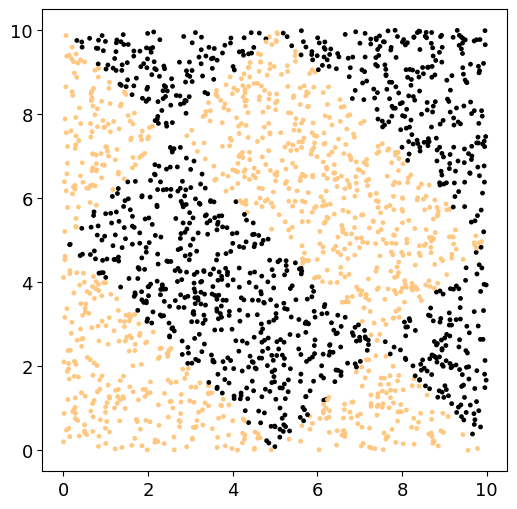

In [12]:
# Keras works with numpy arrays: just use them from the start
TYPE = 3

# data point size
L = 8
# span of each component
B = 10
x = np.loadtxt(filename("data",L,TYPE), delimiter=' ')
y = np.loadtxt(filename("labels",L,TYPE), delimiter=' ')
y = y.astype("int")
print(x.shape)
N = len(x)
# average and std.dev.
x_mean = np.mean(x, axis=0)
x_std  = np.std(x, axis=0)

# dim. of a sample
L = len(x[0])
print(L)

'''
for i in range(5):
    print(x[i],y[i])
'''

N_train = int(perc_train * N)
print(f'data: {N}\ntrain: {N_train}')

plot_data(x,y)

#### Standardize data

In [8]:
print("Before rescaling:\nMean value =", x_mean,"\nStd dev = ", x_std)
x = Standardize(x, x_mean,x_std)
print("After rescaling:\nMean value =", x.mean(axis=0), "\nStd dev =", x.std(axis=0))

Before rescaling:
Mean value = [5.01860571 5.01726228 5.02153857 5.08947968 5.10248206 5.03670082
 4.88645281 5.05411547] 
Std dev =  [2.86912607 2.89535235 2.87312372 2.86324409 2.90278676 2.91948328
 2.92549254 2.89281292]
After rescaling:
Mean value = [ 2.53633226e-15  9.27924404e-16 -1.44884105e-15 -2.38371996e-15
 -2.85274582e-15 -2.02196593e-15 -1.09010023e-15 -1.53632662e-15] 
Std dev = [1. 1. 1. 1. 1. 1. 1. 1.]


#### Split training and test data

In [9]:
(x_train, y_train) = (x[0 : N_train], y[0 : N_train])
(x_test, y_test) = (x[N_train : ], y[N_train : ])
print("Train: ", len(x_train), "\t Validation: ", len(x_test))

Train:  1600 	 Validation:  400


# The original model

The three example models present in the starting jupyther notebook (we show the result just for the first model with 3 layers composed be 20 neurons each).

#### Define the model with Keras / Tensorflow

In [10]:
# reproducibility (?)
np.random.seed(12345)
tf_r.set_seed(12345)

# We use case 1
CASE = 1

if CASE == 1:
    OriginalModel = Sequential()
    OriginalModel.add(Dense(L,input_shape=(L,),activation='relu'))
    OriginalModel.add(Dense(20,activation='relu'))
    OriginalModel.add(Dropout(0.1))
    OriginalModel.add(Dense(20,activation='relu'))
    OriginalModel.add(Dropout(0.1))
    OriginalModel.add(Dense(20,activation='relu'))
    OriginalModel.add(Dropout(0.1))
    OriginalModel.add(Dense(1,activation='sigmoid')) #sigmoid because we want a result between 0 and 1
    nepoch = 500
# as case 1 but one layer shorter
if CASE == 2:
    OriginalModel = Sequential()
    OriginalModel.add(Dense(L,input_shape=(L,),activation='relu'))
    OriginalModel.add(Dense(40,activation='relu'))
    OriginalModel.add(Dropout(0.1))
    OriginalModel.add(Dense(20,activation='relu'))
    OriginalModel.add(Dropout(0.1))
    OriginalModel.add(Dense(1,activation='sigmoid'))
    nepoch = 400
#deeper
if CASE == 3:
    OriginalModel = Sequential()
    OriginalModel.add(Dense(L,input_shape=(L,),activation='relu'))
    OriginalModel.add(Dense(10,activation='relu'))
    OriginalModel.add(Dense(10,activation='relu'))
    OriginalModel.add(Dense(10,activation='relu'))
    OriginalModel.add(Dense(10,activation='relu'))
    OriginalModel.add(Dense(10,activation='relu'))
    OriginalModel.add(Dense(10,activation='relu'))
    OriginalModel.add(Dense(1,activation='sigmoid'))
    nepoch = 400

print(OriginalModel.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │             180 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,113 (4.35 KB)

 Trainable params: 1,113 (4.35 KB)

 Non-trainable params: 0 (0.00 B)

None


#### Optimization method and cost function

In [11]:
OriginalModel.compile(loss='binary_crossentropy', optimizer='RMSprop', #optimizer='adam',
              metrics=['accuracy'])

#### Training

In [13]:
batch_size = 50

In [14]:
fit = OriginalModel.fit(x_train, y_train, epochs = nepoch, batch_size = batch_size, validation_data = (x_test,y_test), verbose=0)

#### Accuracy and Loss

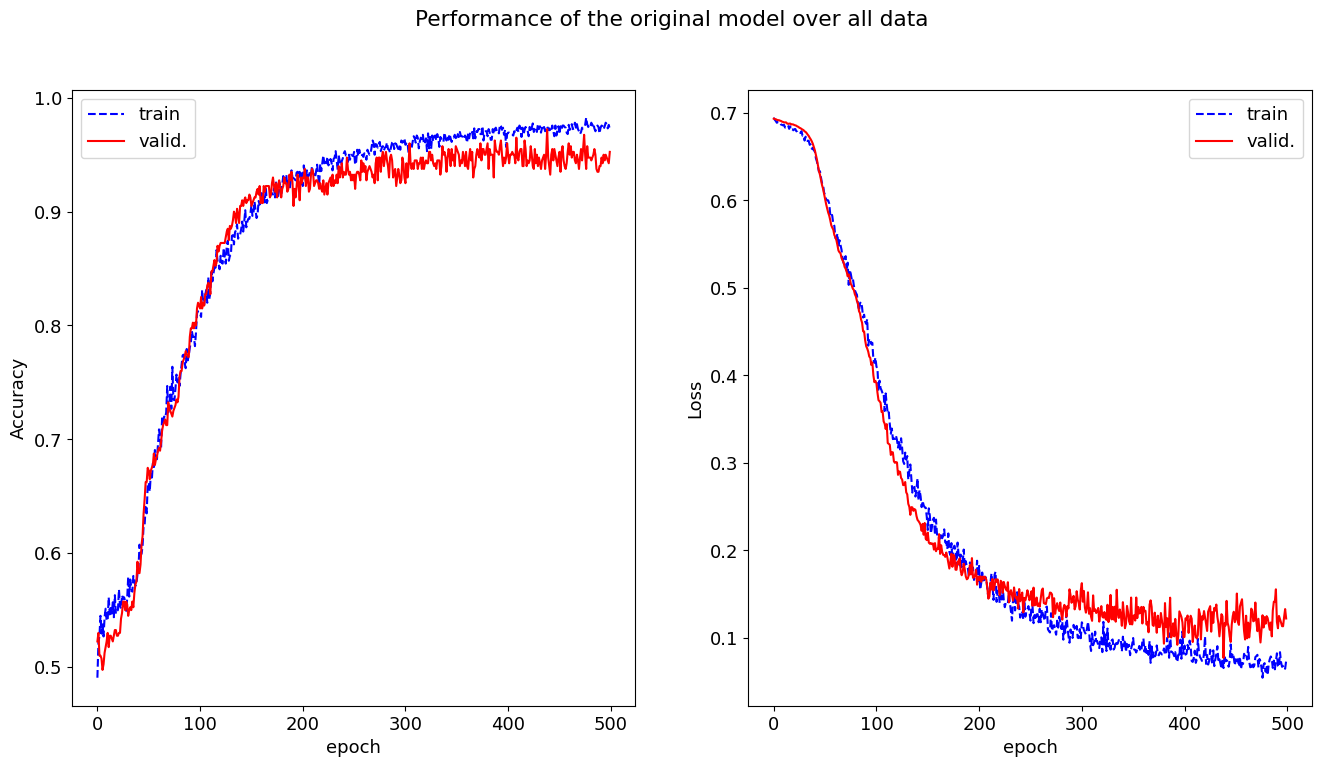

In [19]:
PlotAccuracyAndLoss(fit, whichData="all", whichModel="original")

#### Show predictions

1263/1263 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


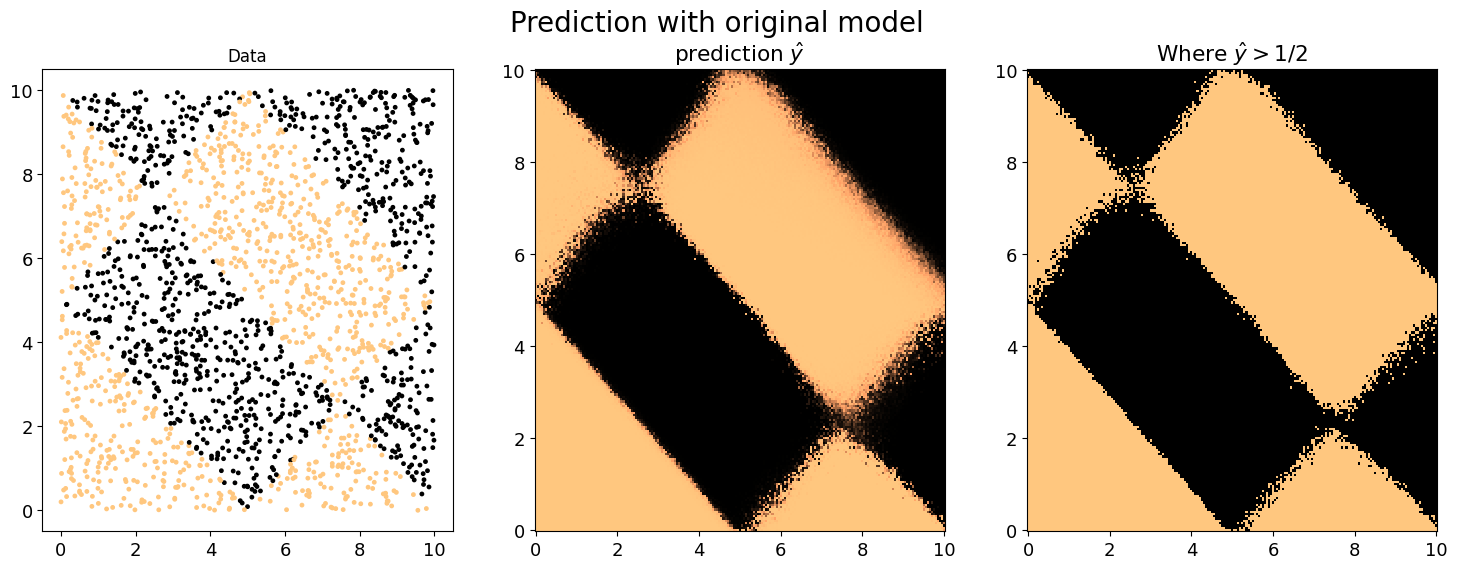

In [27]:
# Cause now the model is trained, after the calling the fit method
PlotPrediction(x,y,x_mean,x_std,OriginalModel,whichModel="original")

#### Confusion Matrix

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


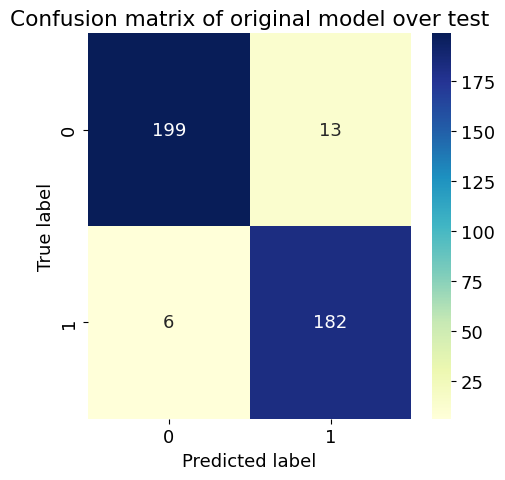

In [28]:
plot_conf_matrix(x_test,y_test,OriginalModel,"original")

# Search for best hyperparameters (hence model)

#### Implementing the Random Search

We implement a random search (over 20 possibile models, more should be better but took too much computational time) using **keras_tuner** in order to find the best hyperparameters of the model into an hyperparameters space composed by the following:
- Layers of the model:&emsp;&nbsp;from 1 to 6
- Neurons of the model:&nbsp; from 10 to 30 with steps of 5
- Activation functions:&emsp;&nbsp;ReLU, sigmoid, tanh, elu
- Optimizers:&emsp;&emsp;&emsp;&emsp;&emsp;&nbsp;ADAM, RMSprop, SGD
- Dropout values:&emsp;&emsp;&emsp;&ensp;0, 0.1, 0.2
- Learning rates:&emsp;&emsp;&emsp;&ensp;&nbsp;from 10e-6 to 10e-1


In [32]:
#We start by building the model with the list of hyperparameters listed above
def build_model(hp):

    model = keras.Sequential()
    #model.add(layers.Flatten())
    # Tune the number of layers of the model
    for i in range(hp.Int("num_layers", 1, 6)):
        model.add(layers.Dense(
                #Define the units and the activation functions
                units=hp.Int(f"units_{i}", min_value=10, max_value=30, step=5),
                activation=hp.Choice("activation", ["relu", "sigmoid", "tanh", "elu"]),
            )
        )
        #Define the dropout values of the model
        model.add(layers.Dropout(rate=hp.Float("dropout", min_value = 0, max_value = 0.2, step = 0.05)))

    #Output layer is composed by 1 neuron since it's classification task
    model.add(layers.Dense(1, activation="sigmoid"))

    #Define the learning rate of the model
    learning_rate = hp.Float("lr", min_value=1e-6, max_value=1e-1, sampling="log")
    model.compile(

        #Define the optimizers of the model
        optimizer=hp.Choice("optimizer", ["adam", "RMSprop", "SGD"]), loss="binary_crossentropy",
        metrics=["accuracy"])
    return model


build_model(keras_tuner.HyperParameters())

#After builiding the model we impose the tuning
tuner = keras_tuner.RandomSearch(
    hypermodel = build_model,
    objective = "val_accuracy",
    max_trials = 20,
    executions_per_trial = 1,
    overwrite = True,
)

#### Actual search for the best hyperparameters

The space of hyperparameters in which we search the best mode is the following.

In [31]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 6, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 30, 'step': 5, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh', 'elu'], 'ordered': False}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.2, 'step': 0.05, 'sampling': 'linear'}
lr (Float)
{'default': 1e-06, 'conditions': [], 'min_value': 1e-06, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'RMSprop', 'SGD'], 'ordered': False}


And here we search.

In [33]:
tuner.search(x_train, y_train, batch_size = 50, epochs = 340, validation_data=(x_valid,y_valid), verbose=0)

#### Summary of the searching results

In [ ]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 3 summary
Hyperparameters:
num_layers: 4
units_0: 15
activation: relu
dropout: 0.05
lr: 7.499123443033092e-06
optimizer: adam
units_1: 10
units_2: 30
units_3: 30
units_4: 30
units_5: 20
Score: 0.7524999976158142

Trial 0 summary
Hyperparameters:
num_layers: 3
units_0: 30
activation: relu
dropout: 0.15000000000000002
lr: 0.011612175361977534
optimizer: RMSprop
units_1: 10
units_2: 10
Score: 0.6850000023841858

Trial 1 summary
Hyperparameters:
num_layers: 5
units_0: 10
activation: sigmoid
dropout: 0.0
lr: 0.00023410915230288735
optimizer: RMSprop
units_1: 20
units_2: 15
units_3: 10
units_4: 10
Score: 0.5699999928474426

Trial 4 summary
Hyperparameters:
num_layers: 6
units_0: 20
activation: tanh
dropout: 0.15000000000000002
lr: 1.2917343126097207e-05
optimizer: SGD
units_1: 25
units_2: 10
units_3: 25
units_4: 25
units_5: 10
Score: 0.5674999952316284

Trial 2 summary


#### Taking best model

We take the best 4 models obtained with that specific training and test sets.

In [ ]:
#The tuner returns the model already trained, and we take the 4 best ones
models = tuner.get_best_models(num_models=4)
#We show the characteristc of the best model
#best_model = models[0]
#best_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (50, 8)                     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (50, 15)                    │             135 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (50, 15)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (50, 10)                    │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (50, 10)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (50, 30)                    │             330 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (50, 30)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (50, 30)                    │             930 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (50, 30)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (50, 1)                     │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,586 (6.20 KB)

 Trainable params: 1,586 (6.20 KB)

 Non-trainable params: 0 (0.00 B)

## K-fold cross validation

We perform a K-fold cross validation to compare the best 4 models obtained on that spacific training set. <br>
We take the training set and we devide it in k-part, each time using one part as validation and all the others as training, and finally we average out the results obtained. <br>
The following function is the one we use for this task.

In [ ]:
# Function to perform the K-fold cross validation
# Take as input a model and it returns
# train_accuracy , val_accuracy , train_loss , val_loss
def k_fold_cross_validation(x_train, y_train, model, k, epoch_kfold, batch_kfold) :

    xtrain = np.array(x_train)
    ytrain = np.array(y_train)

    train_accuracy = np.zeros(shape=epoch_kfold)
    val_accuracy   = np.zeros(shape=epoch_kfold)
    train_loss     = np.zeros(shape=epoch_kfold)
    val_loss       = np.zeros(shape=epoch_kfold)

    # Divide training set in K folds
    x_folds = []
    y_folds = []
    index = np.arange(x_train.shape[0])
    np.random.shuffle(index)
    x_train = x_train[index,:]
    y_train = y_train[index]

    for i in range(k) :
        x_folds.append(x_train[i::k])
        y_folds.append(y_train[i::k])

    # Train and validate
    for test in range(k):

        x_train_fold = [x for i, x in enumerate(x_folds) if i != test]
        y_train_fold = [x for i, x in enumerate(y_folds) if i != test]

        x_train_fold = np.concatenate(x_train_fold)
        y_train_fold = np.concatenate(y_train_fold)

        x_validate_fold = x_folds[test]
        y_validate_fold = y_folds[test]

        fit_kfold = model.fit(x_train_fold , y_train_fold, epochs = epoch_kfold, batch_size = batch_kfold, validation_data = (x_validate_fold,y_validate_fold), verbose=0)
        train_accuracy = train_accuracy + fit_kfold.history['accuracy']
        val_accuracy   = val_accuracy   + fit_kfold.history['val_accuracy']
        train_loss     = train_loss     + fit_kfold.history['loss']
        val_loss       = val_loss       + fit_kfold.history['val_loss']


    train_accuracy = train_accuracy/k
    val_accuracy   = val_accuracy/k
    train_loss     = train_loss/k
    val_loss       = val_loss/k

    return train_accuracy, val_accuracy, train_loss, val_loss

Applying the k-fold cross validation to the 4 best models obtained.
We split the training set in k=5 fold.

In [ ]:
# The four array which will contain the results for the 4 best models
train_accuracy = []
val_accuracy   = []
train_loss     = []
val_loss       = []

num_k = 5
num_epoch = 250
num_batch = int( len(x_train)/(num_k*10) ) #set the batch size as 1/10 ok a k-fold set

for i in range(len(models)):
    tr_acc , vl_acc, tr_loss, vl_loss = k_fold_cross_validation(x_train, y_train, models[i], k=num_k, epoch_kfold=num_epoch, batch_kfold=num_batch)
    train_accuracy.append(tr_acc)
    val_accuracy.append  (vl_acc)
    train_loss.append    (tr_loss)
    val_loss.append      (vl_loss)


#### Results of the k-fold

Showing the performance obtained from the k-fold validation onto the 4 best models, the first in the top to the fourth in the bottom.

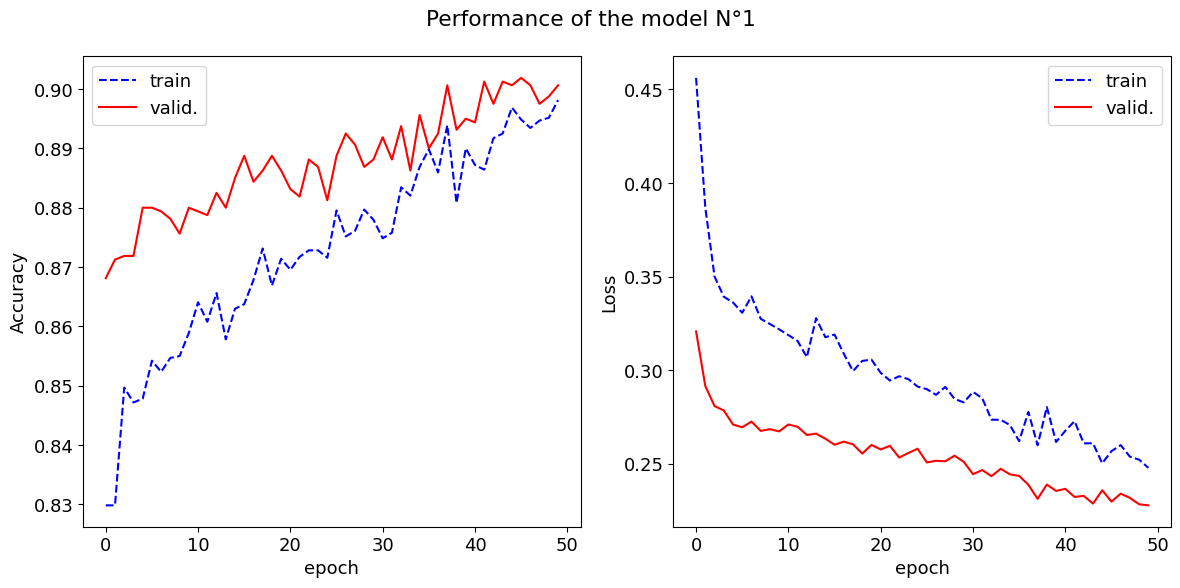

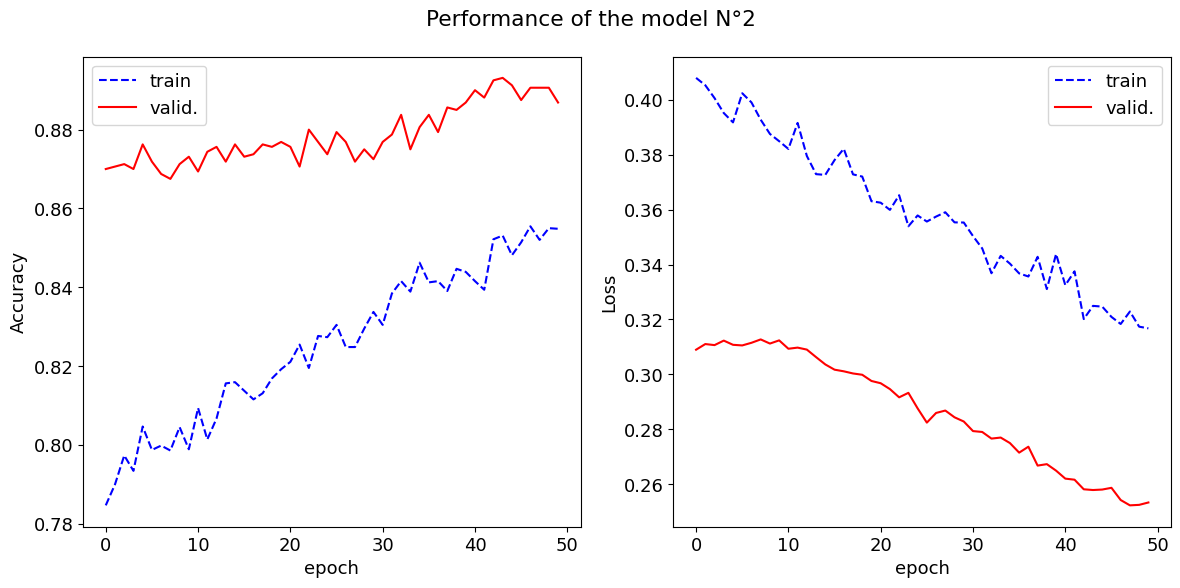

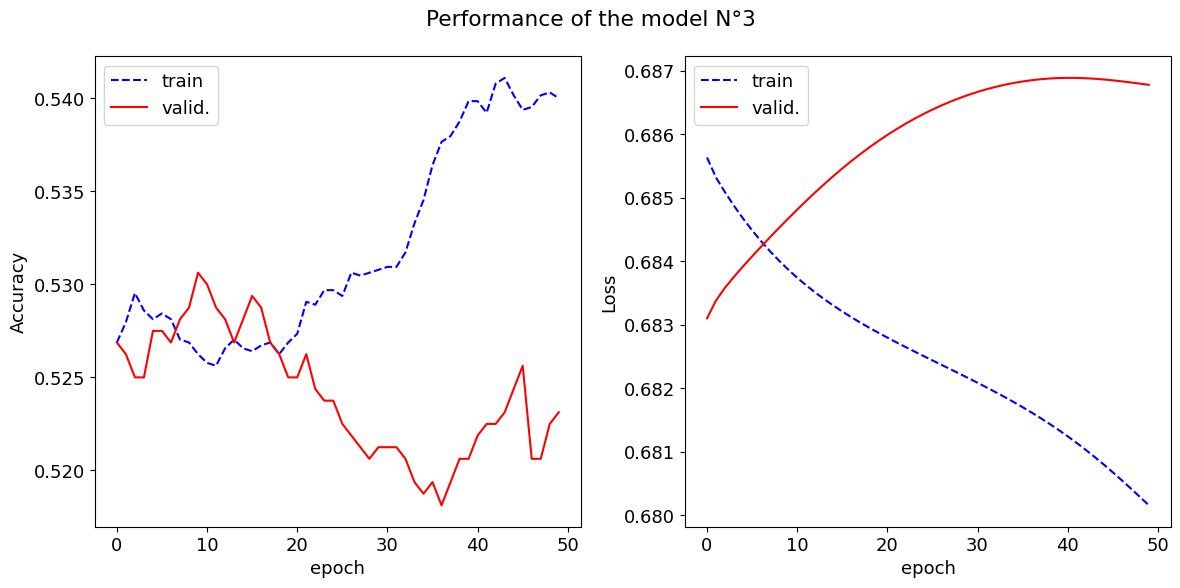

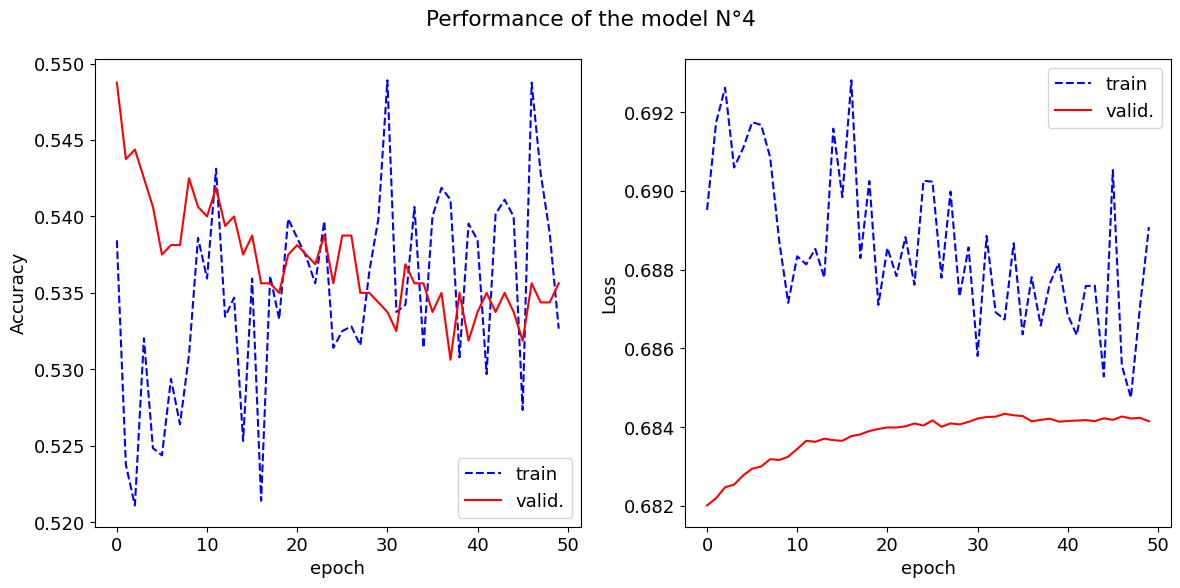

In [ ]:
for i in range(len(models)):

  fig, AX = plt.subplots(1, 2, figsize = (12,6))
  fig.suptitle(f"Performance of the model N°{i+1}")

  ax = AX[0]
  ax.plot(train_accuracy[i], label="train" , c="b", ls="--")
  ax.plot(val_accuracy[i]  , label="valid.", c="r")
  ax.set_xlabel('epoch')
  ax.set_ylabel("Accuracy")
  ax.legend()

  ax = AX[1]
  ax.plot(train_loss[i],label="train" ,c="b",ls="--")
  ax.plot(val_loss[i]  ,label="valid.",c="r")
  ax.set_xlabel('epoch')
  ax.set_ylabel("Loss")
  ax.legend()

  fig.tight_layout()
  plt.show()

  print("\n")

### Choice and train of the best model

From the above analisys we choose to pick as our best model the number **1 YOLO!!!!! DA MODIFICARE**. <br>
We show the structure of this model, we train it using now the whole training set and an *early stopping*

#### Confusion Matrix

We show the confusion matrix onto the test set to check how our best model performs.
A confusion matrix underlines the differences between predicted labels and true labels, to be more specific in this binary classification case we have:
* True Positive &emsp;(TP) : predicted label 1, true label 1
* True Negative &ensp;(TN) : predicted label 0, true label 0
* False Positive &ensp;(FP) : predicted label 1, but true label 0
* False Negative (FN) : predicted label 0, but true label 1

And we recall that the accuracy is corrected guesses / number of total data, so in this case is (TP+TN) / (TP+TN+FP+FN)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


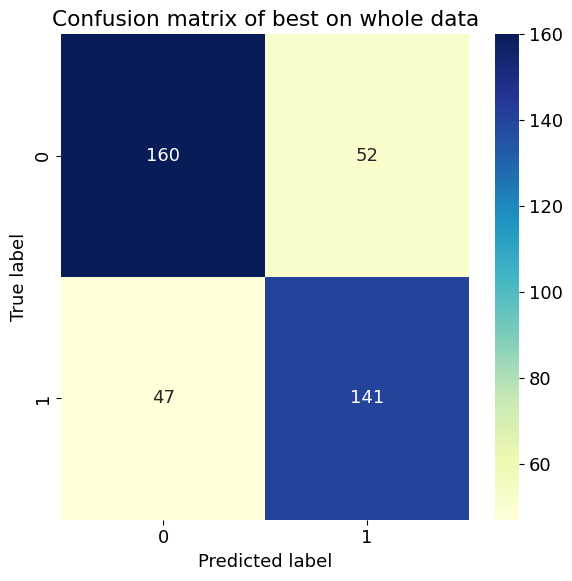

In [ ]:
plot_conf_matrix(x_test,y_test,best_model,"best")

# Check robustness (not overfitting)

We used Augmented data and reduce data to check the result of out best model.

## Augmenting data

We used two approch:
* RAFFAELE SPIEGA MAGLIO IL TUO
* We add same small noise to the original data using small *gaussian* distribution

#### "Linear" augumentation
The first approch here below:

1600
3208


Text(0.5, 1.0, 'Augmented linear data')

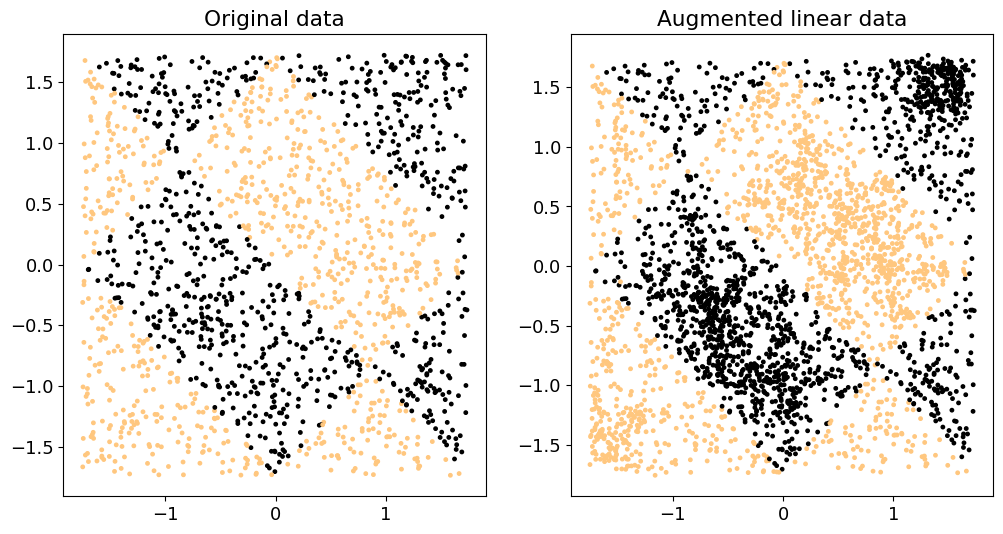

In [ ]:
# For each point P we find the K closest points to P with same color and add M points on the segment connecting them
# For every generated point we consider the closest points to it (how many? validation_size), if the amount of mismatching labels reaches a threshold, such point isn't appended

def augment_data_linear(x_train, y_train, K=2, M=3, keep_old=True, validation_size=10):
    augmented_x = np.array([])
    augmented_y = np.array([])

    if keep_old:
        augmented_x=x_train
        augmented_y=y_train

    for i in range( np.shape(y_train)[0] ):
        x, y = x_train[i], y_train[i]
        eq_colored_x = x_train[y_train == y]
        distances = [np.sqrt(np.sum( (x-z)**2) ) for z in eq_colored_x]

        indices = np.argsort(distances)[1:K+1] # first index is the position of x (distance of x with itself is 0)
        closest_samples = [eq_colored_x[indx] for indx in indices]

        for close_x in closest_samples:
            for _ in range(M):
                new_x = close_x + (x-close_x)*np.random.uniform() + np.random.normal(0,0.025,8)

                #Validation of the new_x point
                dist = np.array([ np.sqrt(np.sum( (new_x-p)**2 )) for p in x_train ])
                validation_indices = np.argsort(dist)[:validation_size]
                validation_labels = np.array([y_train[indx] for indx in validation_indices])

                mismatch = len(validation_labels[validation_labels != y])

                if mismatch/validation_size > 1/5:
                    continue
                else:
                    augmented_x = np.vstack([augmented_x, new_x])
                    augmented_y = np.append(augmented_y, y)

    return np.array(augmented_x), np.array(augmented_y)



fig, axes = plt.subplots(1, 2, figsize=(12, 6))

size = 50
data = np.random.random((size, 8))
dummy_labels = np.random.choice((0, 1), size=size)
#print(np.shape(data))
print(len(y_train))
axes[0].scatter(x_train[:, 0], x_train[:, 1], c=y_train, s=6)
axes[0].set_title("Original data")

augm_data_lin, augm_labels_lin = augment_data_linear(x_train, y_train, K=3, M=3, validation_size=15)
print(len(augm_labels_lin))
#print("augmented data \n",np.shape(augm_data))
axes[1].scatter(augm_data_lin[:, 0], augm_data_lin[:, 1], c=augm_labels_lin, s = 6)
axes[1].set_title("Augmented linear data")

1263/1263 ━━━━━━━━━━━━━━━━━━━━ 1s 716us/step


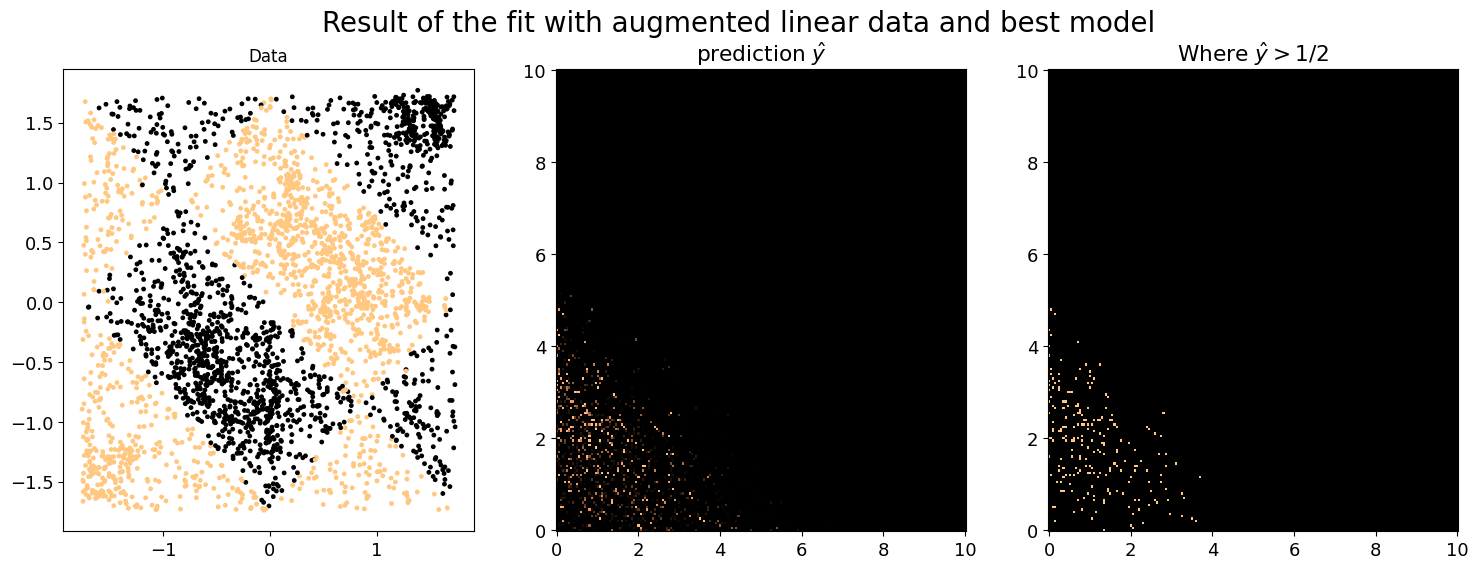

In [ ]:
x_aug_lin_mean = np.mean(augm_data_lin, axis=0)
x_aug_lin_std  = np.std(augm_labels_lin, axis=0)
PlotPrediction(augm_data_lin,augm_labels_lin,x_aug_lin_mean,x_aug_lin_std,best_model,whichData="augmented linear",whichModel="best")

Original:  3173 	 Train:  2538 	 Test:  635


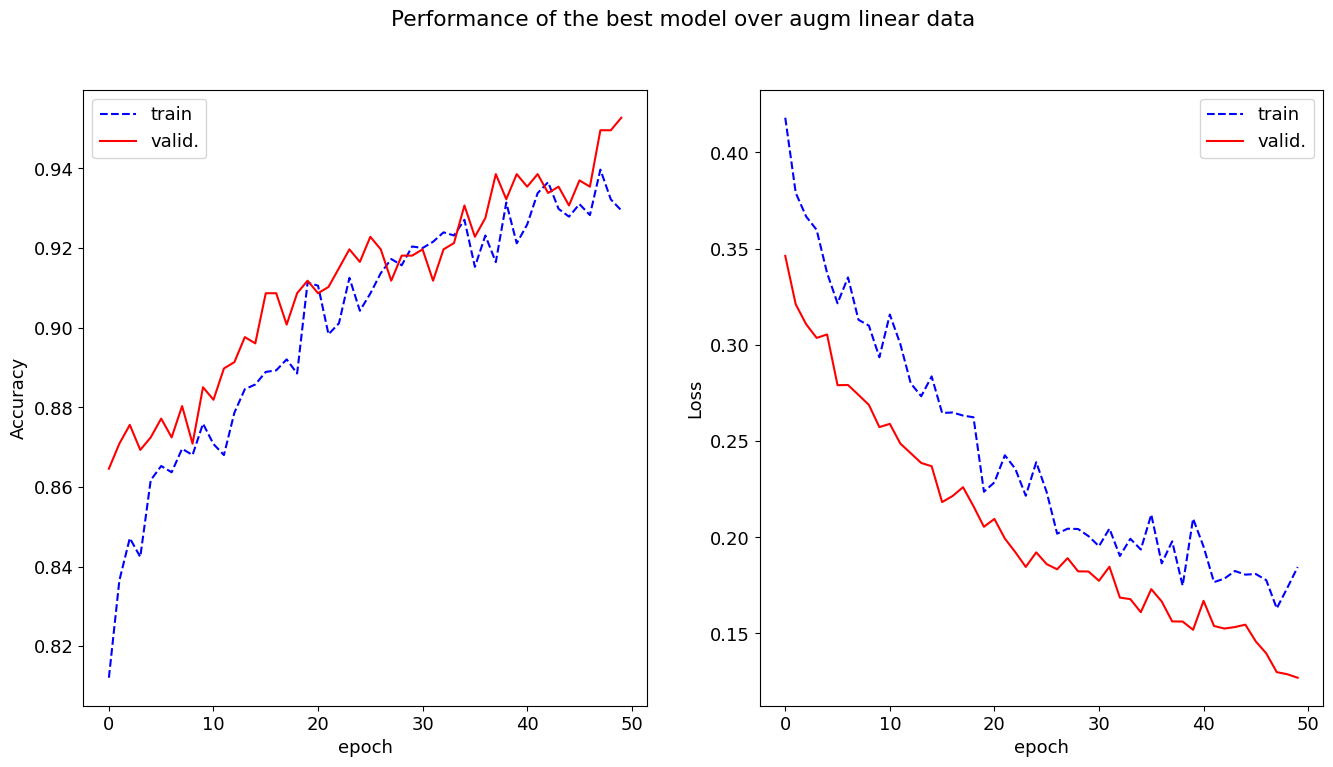

In [ ]:
# E' SBAGLIATO BISOGNA METTERE EVALUATE E NO FIT UNA VOLTA CHE E' ALLENATO, MA ERO STANCO DOPO ORA DI FILA DI PROGRAMMAZIONE,
# LO SISTEMO DOPO SE NESSUNO CI VUOLE SBATTERE LA TESTA

x_tr, y_tr, x_vl, y_vl, _ , _ = reduce_sample(augm_data_lin, augm_labels_lin, perc_train=0.8, reduce_rate=1, replace = False)
fit = best_model.fit(x_tr, y_tr, epochs = 50, batch_size = 10, validation_data = (x_vl, y_vl), verbose=0)
PlotAccuracyAndLoss(fit, whichData="augm linear", whichModel="best")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


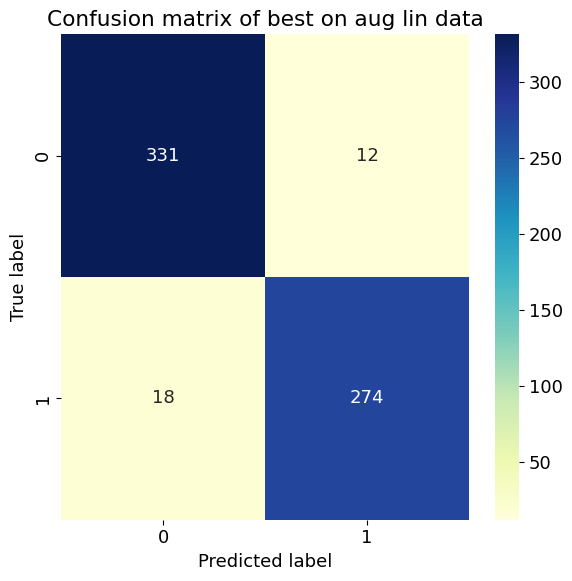

In [ ]:
plot_conf_matrix(x_vl, y_vl,best_model,"aug lin","best")

#### Gaussian Noise
The second approch here below:

1600 8


Text(0.5, 1.0, 'Augmented data')

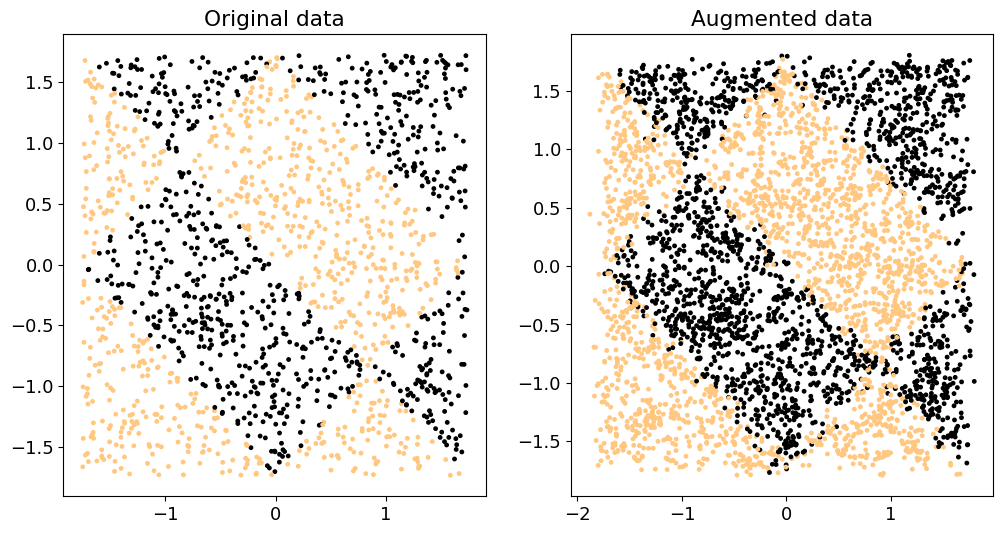

In [ ]:
def augment_data_gaussian(x_train, y_train, N, mu=0, sigma=0.2): # mu and sigma parameters of the noise

    len_x = x_train.shape[0]
    L = x_train.shape[1]
    print(len_x,L)
    N = max(N, len_x) #we create at least a number of data equal to the starting ones

    quot      = N // len_x
    remainder = N % len_x

    index_all = []

    # duplicating the dataset "quot" times, so we'll cover the space equally as the starting data
    for i in range(0, quot):
        index = np.arange( x_train.shape[0] )
        np.random.shuffle(index)
        index_all = np.concatenate( (index_all,index) ).astype(int)


    # finally adding the remaing part of N modulo len_x
    index  = np.arange( x_train.shape[0] )
    chosen = np.random.choice(index, size=remainder, replace=False) #if we want we can also replicate the data
    index_all = np.concatenate( (index_all,chosen) ).astype(int)

    augmented_x = []
    augmented_y = []

    for j in index_all:
        noise = np.random.normal(mu, sigma, L)
        result = np.array(x_train[j,:]) + noise
        augmented_x.append( result )
        augmented_y.append( y_train[j] )

    return np.array(augmented_x), np.array(augmented_y)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].scatter(x_train[:, 0], x_train[:, 1], c=y_train, s=6)
axes[0].set_title("Original data")

# we used as std for the noise 1/20 of the avarage std (accross the L coordinates) of the data
augm_data_gauss, augm_labels_gauss = augment_data_gaussian(x_train, y_train, N=4000, mu=0, sigma=np.mean(np.std(x_train, axis=0))/20)

axes[1].scatter(augm_data_gauss[:, 0], augm_data_gauss[:, 1], c=augm_labels_gauss, s = 6)
axes[1].set_title("Augmented data")

1263/1263 ━━━━━━━━━━━━━━━━━━━━ 1s 696us/step


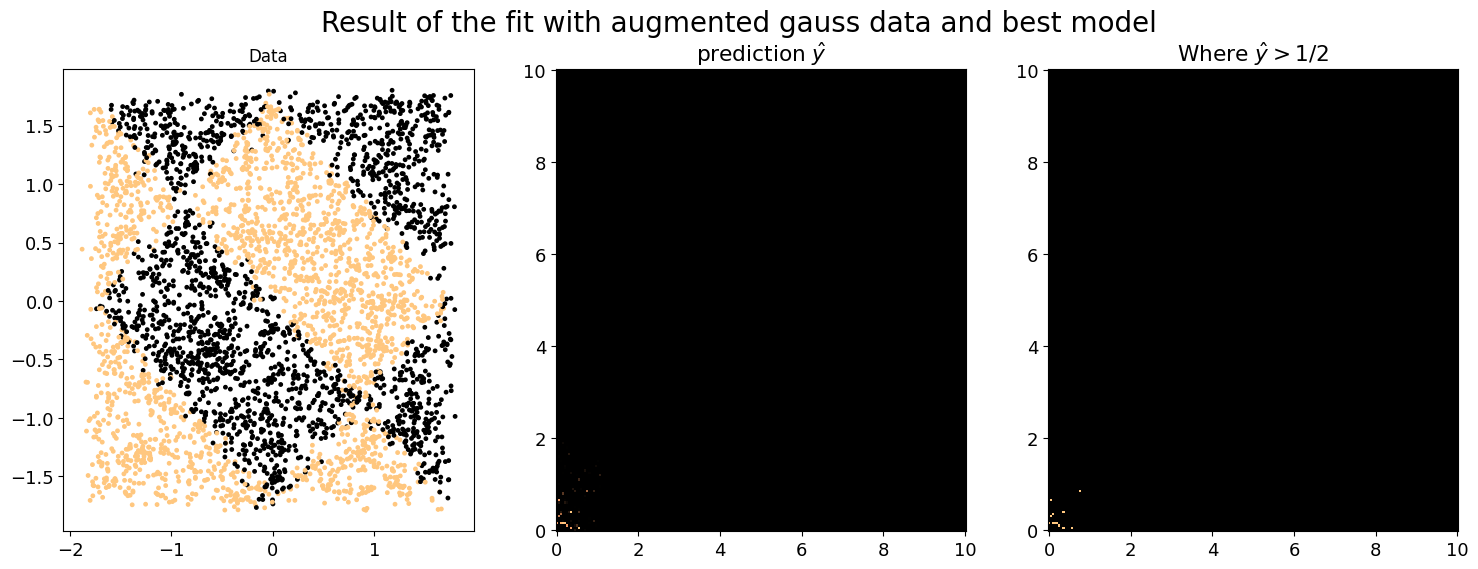

In [ ]:
x_aug_gauss_mean = np.mean(augm_data_gauss, axis=0)
x_aug_gauss_std  = np.std(augm_labels_gauss, axis=0)
PlotPrediction(augm_data_gauss,augm_labels_gauss,x_aug_gauss_mean,x_aug_gauss_std,best_model,whichData="augmented gauss",whichModel="best")

Original:  4000 	 Train:  3200 	 Test:  800


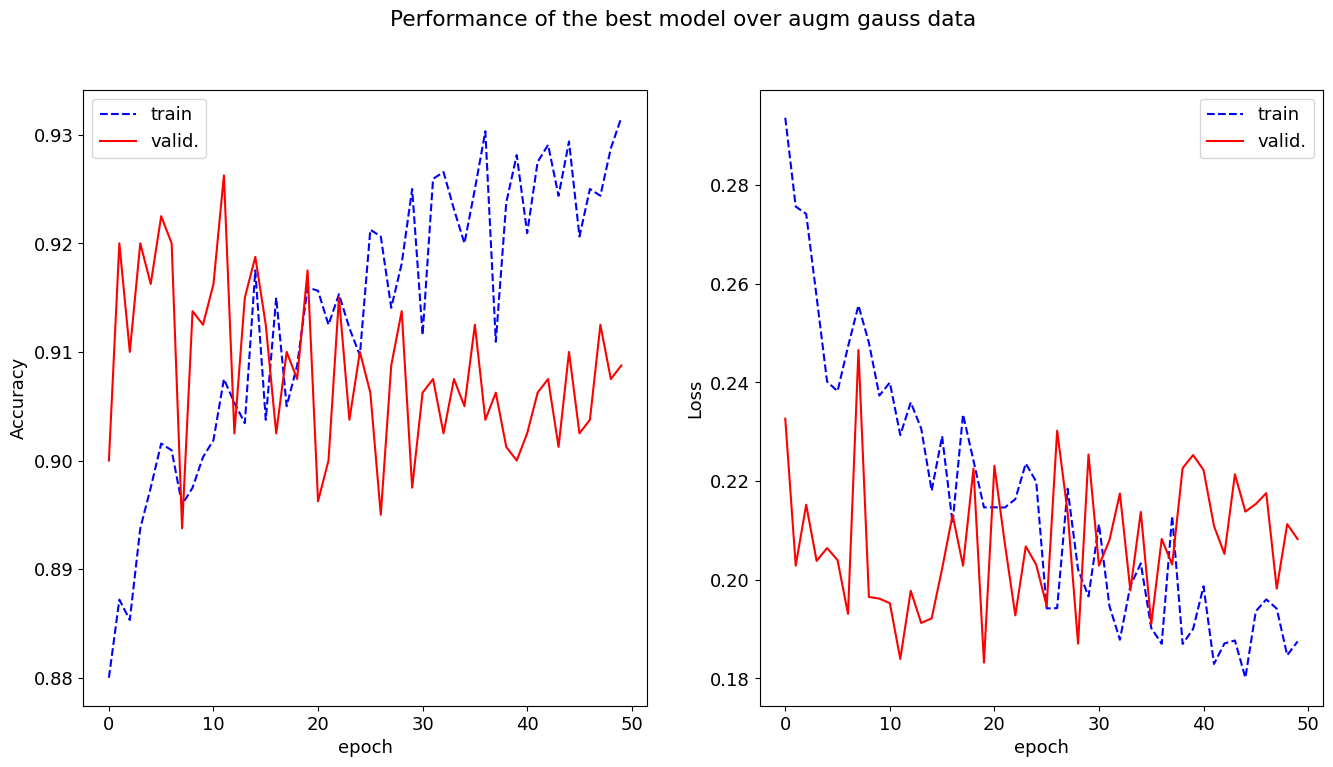

In [ ]:
# E' SBAGLIATO BISOGNA METTERE EVALUATE E NO FIT UNA VOLTA CHE E' ALLENATO, MA ERO STANCO DOPO ORA DI FILA DI PROGRAMMAZIONE,
# LO SISTEMO DOPO SE NESSUNO CI VUOLE SBATTERE LA TESTA

x_tr, y_tr, x_vl, y_vl, _ , _ = reduce_sample(augm_data_gauss, augm_labels_gauss, perc_train=0.8, reduce_rate=1, replace = False)
fit = best_model.fit(x_tr, y_tr, epochs = 50, batch_size = 10, validation_data = (x_vl, y_vl), verbose=0)
PlotAccuracyAndLoss(fit, whichData="augm gauss", whichModel="best")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


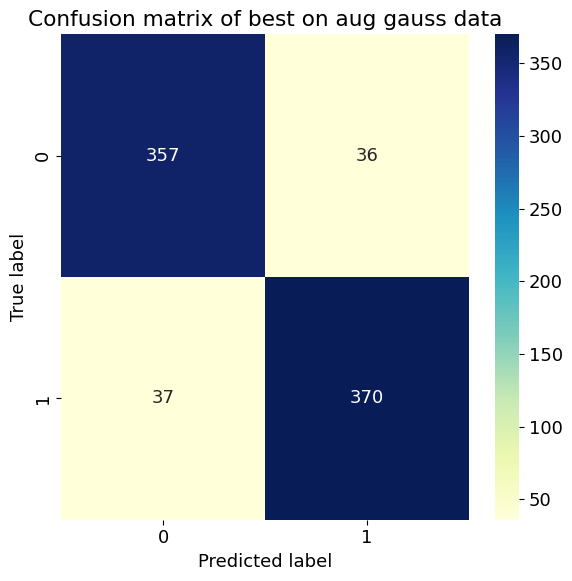

In [ ]:
plot_conf_matrix(x_vl, y_vl,best_model,"aug gauss","best")

## Reduced sample

From the starting sample we create a reduce dataset (using the "reduce_sample" function implemented at the beggining).
We achieve this choising randomly a fraction of the all data, we can be done with or without replacement (i.e. the possibility of taking multiple copies of one specific data).
This as multiple reasons, the most relevant be to see if our best trained model is robust to the change odf the dataset (in other words to check if we didn'to overfitted) and taking less computation effort using a reduce sample instead of of an augmented one.

In [ ]:
# Remember x and y (from the data file) made up the original dataset
x_red_train, y_red_train, x_red_test, y_red_test, x_red_M, x_red_S= reduce_sample(x, y, reduce_rate=0.6, perc_train=0.8, replace = True)

Original:  2000 	 Train:  960 	 Test:  240


1263/1263 ━━━━━━━━━━━━━━━━━━━━ 1s 697us/step


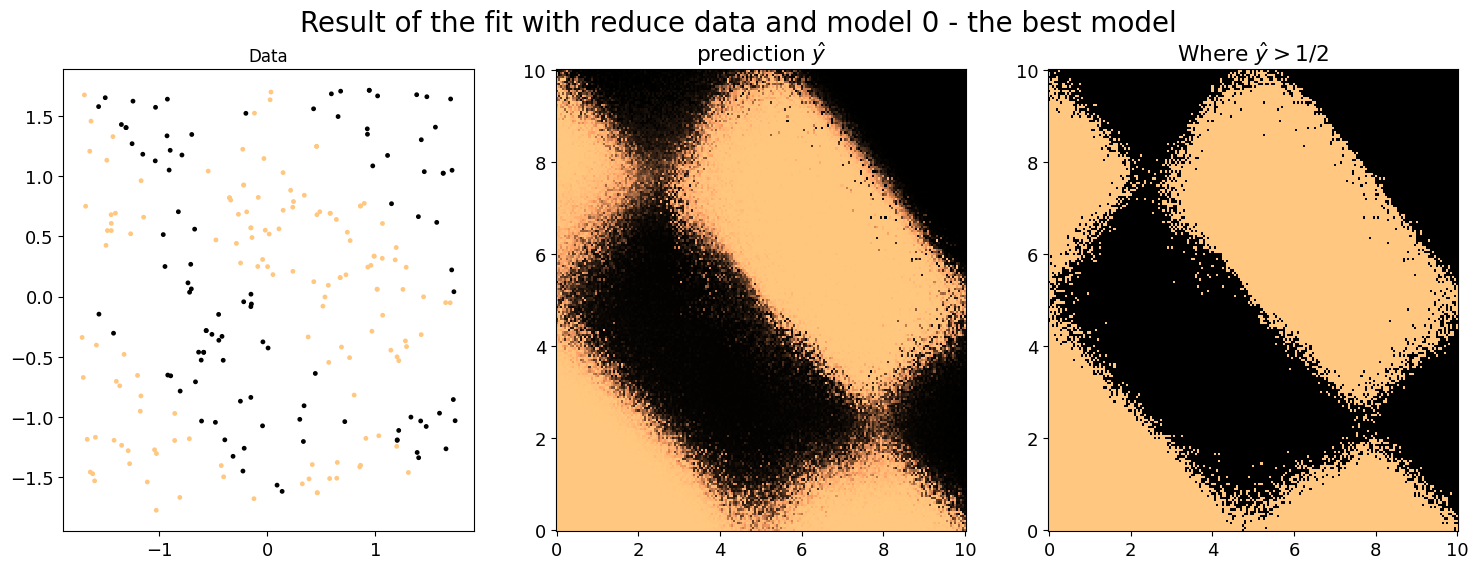

In [ ]:
PlotPrediction(x_red_test, y_red_test, x_red_M, x_red_S, best_model, "reduce", "model 0 - the best")

In [ ]:
x_tr, y_tr, x_vl, y_vl, _ , _ = reduce_sample(augm_data_gauss, augm_labels_gauss, perc_train=0.8, reduce_rate=1, replace = False)
fit = best_model.fit(x_tr, y_tr, epochs = 50, batch_size = 10, validation_data = (x_vl, y_vl), verbose=0)
PlotAccuracyAndLoss(fit, whichData="augm gauss", whichModel="best")

In [ ]:
plot_conf_matrix(x_vl, y_vl,best_model,"reduce","best")